# Asian options
Recall that a European call option is a contract whose payoff at expiration is given by $\max(s_t - K, 0)$, where $K$ is the predetermined strike price and $s_t$ is the asset value at expiration time $t$.  By design, European call options are then path-independent, but also susceptible to "last-minute" volatility.

Asian call (put) options are an alternative contract trying to address the European option's susceptibility to short-term volatility, by defining the payoff at expiration to be $\max(\bar{S} - K, 0)$ ($\max(K - \bar{S}, 0)$), where $\bar{S}$ is either the arithmetic average of the stock prices $\bar{S} = \frac{1}{N} \sum_{i=1}^N S_{t_i}$ or the geometric average $\bar{S} = \left(\prod_{i=1}^N S_{t_i} \right)^{1/N}$, where $N$ is the number of subdivisions of the time interval $[0,t]$.

As such, Asian options are path-dependent.  The geometric Asian option has a closed-form solution, while the arithmetic Asian option has not.  We will model both via Monte-Carlo methods, and compare the geometric simulated price with the computed price.

Later in the notebook, we will also explore some delta-hedging strategies for arithmetic Asian options.

### Geometric Asian options
We first consider Asian options whose value at expiration is given by $\max(\bar{S} - K, 0)$, where $\bar{S}$ is the geometric average of the process $S_t$.

>**Note.** The closed-form solution for fair pricing of geometric Asian options assumes that $\bar{S}$ is the continuous-time geometric average.  In reality, it will be a geometric average sampled at $N$ points.  If $N$ is sufficiently large, that should give a good enough approximation.

##### Closed-form solution

>**Theorem.** Assume that $S_t$ follows a GBM distribution with yearly volatility $\sigma$.  Assume also that the risk-free interest rate is $r$.  Let $K$ be the strike price and set 
>$$
>b = \frac{1}{2} \left(r - \frac{\sigma^2}{6} \right), \quad d_1 = \sqrt{3}\frac{\log\frac{S_0}{K} + \left(b + \frac{\sigma^2}{6}\right)t}{\sigma\sqrt{t}}, \quad d_2 = d_1 - \frac{\sigma \sqrt{t}}{\sqrt{3}}.
>$$
>Then the fair price for a geometric Asian call option at time $t$ is
>$$
>C_0 = S_0 e^{(b-r)t} \Phi(d_1) - K e^{-rt} \Phi(d_2)
>$$
>and the fair price for a geometric Asian put option at time $t$ is
>$$
>P_0 = K e^{-rt} \Phi(-d_2) - S_0 e^{(b-r)t} \Phi(-d_1).
>$$
>Note that we still have put-call parity:
>$$
>C_0 - P_0 = S_0 e^{(b-r)t} - K e^{-rt}.
>$$

We implement the geometric Asian option pricing via the following code, available in `utils.py`.
```python
# Geometric Asian option
def gao_price(S0, K, sigma, t, r, option_type='call'):
    '''Geometric Asian option pricer
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate

    Return:
    Computed value of a geometric Asian call/put option (float)
    '''
    b = (r - sigma**2 / 6) / 2
    d1 = np.sqrt(3)*(np.log(S0/K) + (b + sigma**2 / 6)*t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t/3)

    if option_type == 'put':
        return K * np.exp(-r*t) * norm.cdf(-d2) - S0 * np.exp((b-r)*t) * norm.cdf(-d1)
    elif option_type == 'call':
        return S0 * np.exp((b-r)*t) * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))
```

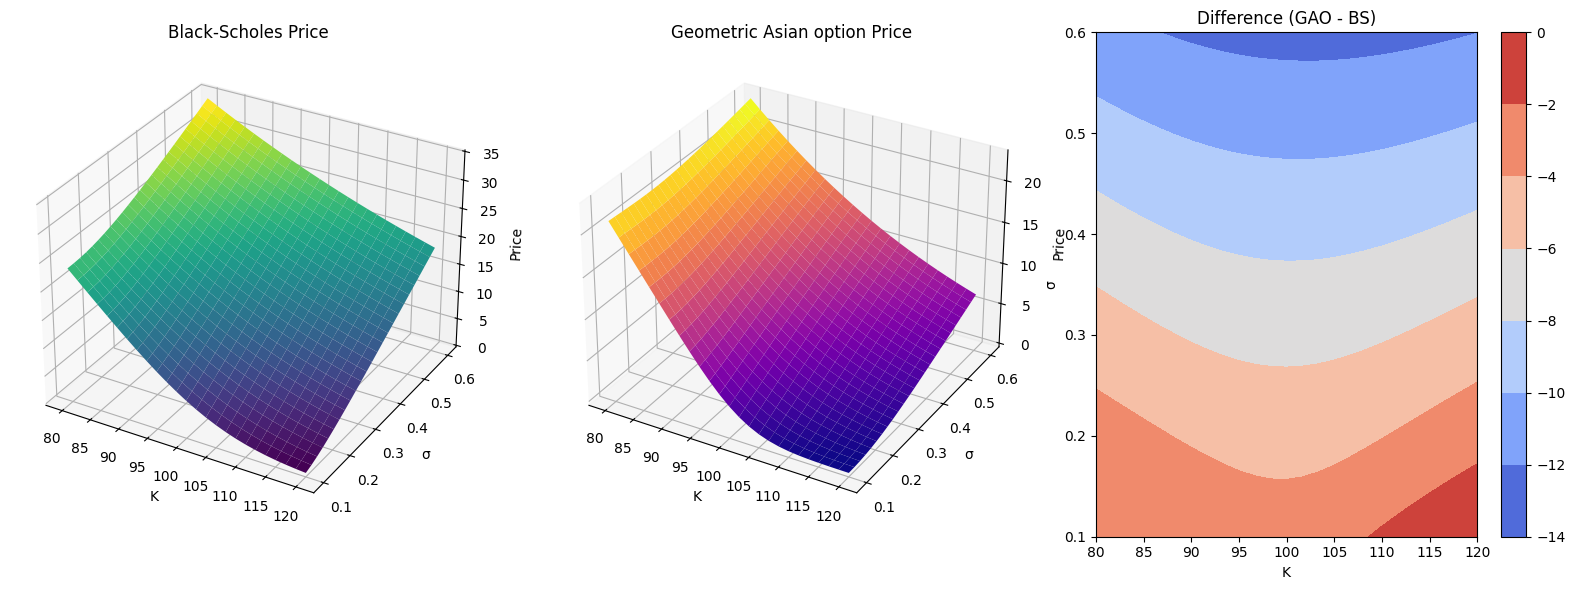

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

from utils import bs_price, gao_price

S0 = 100
t = 1.0
r = 0.045

K_values = np.linspace(80, 120, 25)
sigma_values = np.linspace(0.1, 0.6, 25)


# Compare bs_price and gao_price over K and sigma, fixing t and r
K, sigma = np.meshgrid(K_values, sigma_values)

bs = np.vectorize(bs_price)(S0, K, sigma, t, r)
gao = np.vectorize(gao_price)(S0, K, sigma, t, r)
diff = gao - bs

fig = plt.figure(figsize=(16, 6))

# --- 3D Surface: BS price ---
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot_surface(K, sigma, bs, cmap="viridis")
ax1.set_title("Black-Scholes Price")
ax1.set_xlabel("K")
ax1.set_ylabel("σ")
ax1.set_zlabel("Price")

# --- 3D Surface: GAO price ---
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot_surface(K, sigma, gao, cmap="plasma")
ax2.set_title("Geometric Asian option Price")
ax2.set_xlabel("K")
ax2.set_ylabel("σ")
ax2.set_zlabel("Price")

# --- Heatmap: Difference ---
ax3 = fig.add_subplot(133)
c = ax3.contourf(K, sigma, diff, cmap="coolwarm")
plt.colorbar(c, ax=ax3)
ax3.set_title("Difference (GAO - BS)")
ax3.set_xlabel("K")
ax3.set_ylabel("σ")

plt.tight_layout()
plt.show()

Note how the Asian option is, as expected, less susceptible of volatility increases.  Note also that Asian options are cheaper than European options, and that the difference in prices becomes greater as volatility increases.

##### Monte-Carlo simulation
As with European options, we can estimate the fair price by Monte-Carlo methods.

In [2]:
from utils import GBM_paths

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")


def monte_carlo_gao(S0, K, sigma, t, r, mu, n_sims, n_steps, option_type="call"):
    """
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths

    Returns:
    Estimated option price (float), standard deviation (float)
    """
    paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)
    S = np.exp(np.mean(np.log(paths), axis=1))  # geometric mean of prices

    if option_type == "call":
        payoffs = np.maximum(S - K, 0)
    elif option_type == "put":
        payoffs = np.maximum(K - S, 0)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))

    discounted_payoff = np.exp(-r * t) * payoffs

    return np.mean(discounted_payoff), np.std(discounted_payoff) / np.sqrt(n_sims)

We can then compare how the Monte-Carlo simulation stacks up against the closed-form formula.  In this case, we also need to specify the number of steps.  Since we are looking at a 1-year horizon, we take `n_steps` to be 252.

In [3]:
simulations = [10, 100, 1_000, 10_000, 100_000, 1_000_000]

S0 = 100
r = 0.0425
t = 1
K = S0
sigma = 0.43
mu = 0
n_steps = 252

analytic_price = gao_price(S0, K, sigma, t, r)
print(f"Computed fair price: ${analytic_price:.2f}")

for n_sims in simulations:
    call_value, std_err = monte_carlo_gao(S0, K, sigma, t, r, mu, n_sims, n_steps)
    print(
        f"Estimated call value with {n_sims} simulations: ${call_value:.2f} with standard error \
{std_err:.5f}"
    )

Computed fair price: $9.78
Estimated call value with 10 simulations: $10.91 with standard error 3.13837
Estimated call value with 100 simulations: $9.56 with standard error 1.75269
Estimated call value with 1000 simulations: $10.55 with standard error 0.54873
Estimated call value with 10000 simulations: $9.92 with standard error 0.16667
Estimated call value with 100000 simulations: $9.73 with standard error 0.05135
Estimated call value with 1000000 simulations: $9.78 with standard error 0.01642


As before, the Monte-Carlo price converges to the computed fair price as the number of simulations increases.

### Arithmetic Asian options
If the value of the call (put) option is given by $\max(\bar{S} - K, 0)$ ($\max(K-\bar{S}, 0)$, respectively) with $\bar{S}$ the arithmetic mean, then we have no closed-form solution, and we need to resort to Monte-Carlo methods.

The following code is available in `utils.py`, and comprehends both geometric and arithmetic Asian options.

```python
def monte_carlo_asian(S0, K, sigma, t, r, mu, n_sims, n_steps, geometric=False, return_distribution=True, option_type="call"):
    """
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in the average

    Returns:
    If return_distribution is true, returns distribution of simulated values;
      if false, returns the average payoff of option
    """
    paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)
    if geometric:
        S = gmean(paths, axis=1)  # geometric mean of prices
    else:
        S = np.mean(paths, axis=1)  # arithmetic mean of prices

    if option_type == "call":
        discounted_payoff = np.exp(-r * t) * np.maximum(S - K, 0)
    elif option_type == "put":
        discounted_payoff = np.exp(-r * t) * np.maximum(K - S, 0)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))

    if return_distribution:
        return discounted_payoff
    else:
        return np.mean(discounted_payoff)
```

The simulated distribution of profits of Asian call options is then as follows (from the point of view of the option buyer).

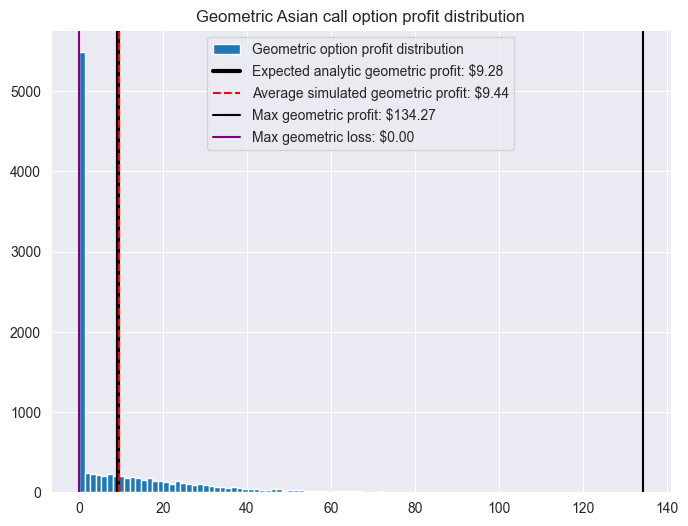

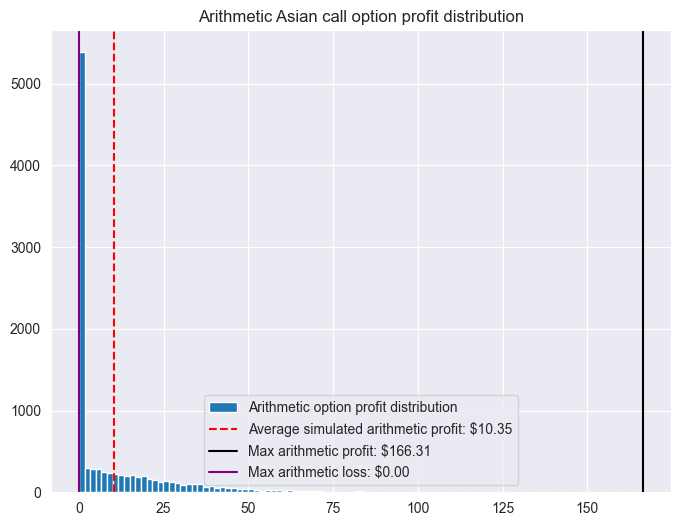

In [4]:
from utils import monte_carlo_asian

S0 = 100
K = 100
sigma = 0.4
t = 1
mu = 0
r = 0.045
n_sims = 10_000
n_steps = 252

geom_profit = monte_carlo_asian(S0, K, sigma, t, r, mu, n_sims, n_steps, geometric=True)
geom_analytic_price = gao_price(S0, K, sigma, t, r)
average_geom_profit = np.mean(geom_profit)
max_geom_profit = np.max(geom_profit)
min_geom_profit = np.min(geom_profit)

arit_profit = monte_carlo_asian(S0, K, sigma, t, r, mu, n_sims, n_steps)
average_arit_profit = np.mean(arit_profit)
max_arit_profit = np.max(arit_profit)
min_arit_profit = np.min(arit_profit)

plt.figure(figsize=(8, 6))
plt.title("Geometric Asian call option profit distribution")

plt.hist(geom_profit, bins=100, label="Geometric option profit distribution")
plt.axvline(
    geom_analytic_price,
    color="black",
    lw=3,
    label=f"Expected analytic geometric profit: ${geom_analytic_price:.2f}",
)
plt.axvline(
    average_geom_profit,
    ls="--",
    color="red",
    label=f"Average simulated geometric profit: ${average_geom_profit:.2f}",
)
plt.axvline(
    max_geom_profit,
    color="black",
    label=f"Max geometric profit: ${max_geom_profit:.2f}",
)
plt.axvline(
    min_geom_profit, color="purple", label=f"Max geometric loss: ${min_geom_profit:.2f}"
)
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.title("Arithmetic Asian call option profit distribution")

plt.hist(arit_profit, bins=100, label="Arithmetic option profit distribution")
plt.axvline(
    average_arit_profit,
    ls="--",
    color="red",
    label=f"Average simulated arithmetic profit: ${average_arit_profit:.2f}",
)
plt.axvline(
    max_arit_profit,
    color="black",
    label=f"Max arithmetic profit: ${max_arit_profit:.2f}",
)
plt.axvline(
    min_arit_profit,
    color="purple",
    label=f"Max arithmetic loss: ${min_arit_profit:.2f}",
)

plt.legend()
plt.show()

Note that the arithmetic option seems to have higher profit than the geometric counterpart.  We can explore this further by comparing the simulated returns of geometric and arithmetic Asian options directly.

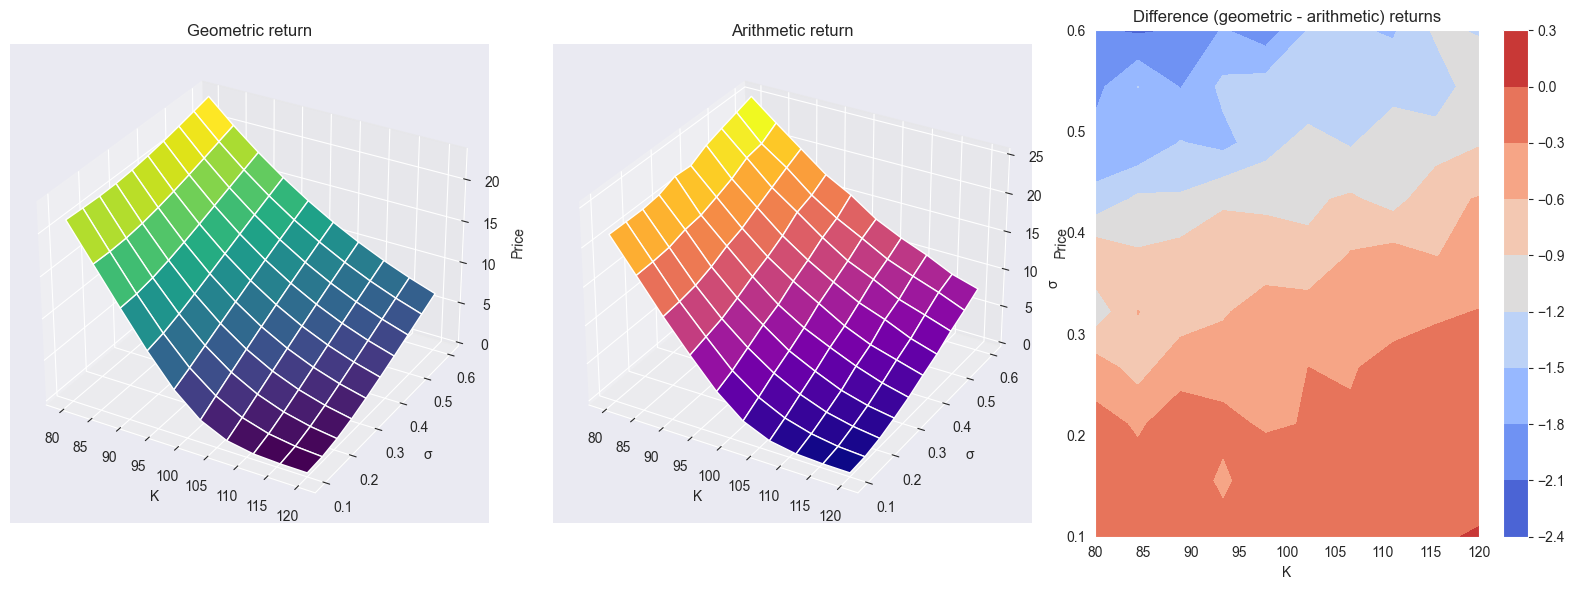

In [5]:
S0 = 100
t = 1
mu = 0
r = 0.045
n_sims = 10_000
n_steps = 252

K_values = np.linspace(80, 120, 10)
sigma_values = np.linspace(0.1, 0.6, 10)


# Compare geometric and arithmetic Asian options prices over K and sigma, fixing t and r
K, sigma = np.meshgrid(K_values, sigma_values)

geometric = np.vectorize(gao_price)(S0, K, sigma, t, r)
arithmetic = np.vectorize(monte_carlo_asian)(
    S0, K, sigma, t, r, mu, n_sims, n_steps, return_distribution=False
)
diff = geometric - arithmetic

fig = plt.figure(figsize=(16, 6))

# --- 3D Surface: BS price ---
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot_surface(K, sigma, geometric, cmap="viridis")
ax1.set_title("Geometric return")
ax1.set_xlabel("K")
ax1.set_ylabel("σ")
ax1.set_zlabel("Price")

# --- 3D Surface: GAO price ---
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot_surface(K, sigma, arithmetic, cmap="plasma")
ax2.set_title("Arithmetic return")
ax2.set_xlabel("K")
ax2.set_ylabel("σ")
ax2.set_zlabel("Price")

# --- Heatmap: Difference ---
ax3 = fig.add_subplot(133)
c = ax3.contourf(K, sigma, diff, cmap="coolwarm")
plt.colorbar(c, ax=ax3)
ax3.set_title("Difference (geometric - arithmetic) returns")
ax3.set_xlabel("K")
ax3.set_ylabel("σ")

plt.tight_layout()
plt.show()

Note that arithmetic options have a higher return than geometric ones, which should be expected since geometric means are bounded above by arithmetic means.

Arithmetic options look also more susceptible to volatility, which can be explained by the fact that geometric averages are more susceptible to small prices and less to large prices than arithmetic averages.  In fact, there seems to be a significant correlation between the difference in returns and volatility, with difference in returns being higher for higher volatility.

### $\Delta$-hedging for Asian call options
In this section, we explore some $\Delta$-hedging strategies for arithmetic and geometric Asian call options.  We focus on call options for simplicity, because of put-call parity.

##### Finding $\Delta$
We start with geometric Asian options, since we have a closed form.  We compute
$$
\begin{split}
\Delta_{C_0} &= \frac{\partial C_0}{\partial S_0} = \frac{\partial}{\partial S_0} \left( S_0 e^{(b-r)t} \Phi(d_1) - K e^{-rt} \Phi(d_2) \right) \\
&= e^{(b-r)t} \Phi(d_1) + S_0 e^{(b-r)t} \varphi(d_1) \frac{\partial d_1}{\partial S_0} - K e^{-rt} \varphi(d_2) \frac{\partial d_2}{\partial S_0},
\end{split}
$$
where $\varphi(x) = \frac{1}{\sqrt{2\pi}} e^{x^2/2}$ is the density function of the normal distribution.  Note that
$$
\frac{\partial d_2}{\partial S_0} = \frac{\partial}{\partial S_0} \left(d_1 - \sigma\sqrt{t/3}\right) = \frac{\partial d_1}{\partial S_0},
$$
and that
$$
\begin{split}
&S_0 e^{(b-r)t} \varphi(d_1) - K e^{-rt} \varphi(d_2) = S_0 e^{(b-r)t} \frac{1}{\sqrt{2\pi}} e^{-d_1^2/2} - K e^{-rt} \frac{1}{\sqrt{2\pi}} e^{-d_1^2/2} e^{\sigma^2 t / 6} \\
&\qquad= \frac{e^{-d_1^2/2}}{\sqrt{2\pi}} \left(S_0 e^{(b-r)t} - K e^{-rt} e^{\frac{\sigma\sqrt{t}}{\sqrt{3}}d_1} e^{-\sigma^2 t / 6} \right) \\
&\qquad= \varphi(d_1) \left( S_0 e^{(b-r)t} - K e^{-rt} e^{\ln \frac{S_0}{K} + bt + \frac{\sigma^2 t}{6}} e^{-\frac{\sigma^2 t}{6}} \right) = 0.
\end{split}
$$
Hence, we conclude that 
$$
\Delta_{C_0} = e^{(b-r)t} \Phi(d_1).
$$
By put-call parity, we also find the delta of a geometric Asian put option:
$$
\Delta_{P_0} = \Delta_{C_0} - e^{(b-r)t} = e^{(b-r)t} \left( \Phi(d_1) - 1 \right).
$$
The following code implements geometric deltas and is available in `utils.py`.
```python
def gao_delta(S0, K, sigma, t, r, option_type='call'):
    '''Geometric Asian option delta
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free Interest rate
    
    Return:
    Delta of a geometric Asian call/put option (float)
    '''
    b = (r - sigma**2 / 6) / 2
    d1 = np.sqrt(3)*(np.log(S0/K) + (b + sigma**2 / 6)*t) / (sigma * np.sqrt(t))

    if option_type == 'put':
        return np.exp((b-r)*t) * (norm.cdf(d1) - 1)
    elif option_type == 'call':
        return np.exp((b-r)*t) * norm.cdf(d1)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))
```

Since arithmetic Asian options don't have a closed-form solution, we need to resort to numerical approximations.  There are fundamentally two alternatives:
- use the geometric Asian option delta as a proxy for the arithmetic one;
- approximate the arithmetic delta numerically bumping $S_0$ by a small $\varepsilon$ and computing $\Delta_{C_0} \simeq \frac{C_0(S_0 + \varepsilon) - C_0(S_0)}{\varepsilon}$, where $C_0$ is the price of the arithmetic Asian option estimated via Monte-Carlo simulations.

Because the second alternative is computationally very expensive, we will focus on the first approach.  Note that we should expect the delta of a geometric Asian option to be smaller than that of the arithmetic counterpart, at least for a reasonably small volatility, with the difference being of order $O(\sigma\sqrt{t})$.

##### Exploratory delta-hedging
With the caveats highlighted above, we try now to implement an exploratory delta-hedging strategy for geometric and arithmetic Asian options.  Because we will be using the closed-form delta from the geometric Asian option for both geometric and arithmetic options, we should expect better performance hedging geometric options.

The following code implements delta-hedging, and is available in `utils.py`.  For simplicity, in our code we will hedge at every simulation step (`n_hedges` and `n_steps` will be the same).
```python
def monte_carlo_asian_hedged(S0, K, sigma, t, r, mu, n_sims, n_steps, geometric=False, return_distribution=True, option_type="call"):
    """
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in the average

    Returns:
    If return_distribution is true, returns distribution of simulated values;
      if false, returns the average payoff of option
    """
    paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)
    if geometric:
        S = gmean(paths, axis=1)  # geometric mean of prices
    else:
        S = np.mean(paths, axis=1)  # arithmetic mean of prices

    if option_type == "call":
        discounted_payoff = np.exp(-r * t) * np.maximum(S - K, 0)
    elif option_type == "put":
        discounted_payoff = np.exp(-r * t) * np.maximum(K - S, 0)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))

    times = np.linspace(0, t, n_steps + 1)
    deltas = gao_delta(paths[:,0:n_steps], K, sigma, (t-times)[0:n_steps], r, option_type=option_type)

    stock_profits_discounted = paths[:,1:n_steps + 1] - paths[:,0:n_steps] * np.exp(r*t/n_steps) * np.exp(-r*times[1:n_steps+1])*deltas
    profit_of_call_with_hedging = discounted_payoff - np.sum(stock_profits_discounted, axis=1)

    if return_distribution:
        return profit_of_call_with_hedging
    else:
        return np.mean(profit_of_call_with_hedging)
```

Below we simulate the effect of the number of samples/hedges on the profit of a market-maker selling a geometric Asian call option.  We assume a transaction price of $0.0020 per transaction.

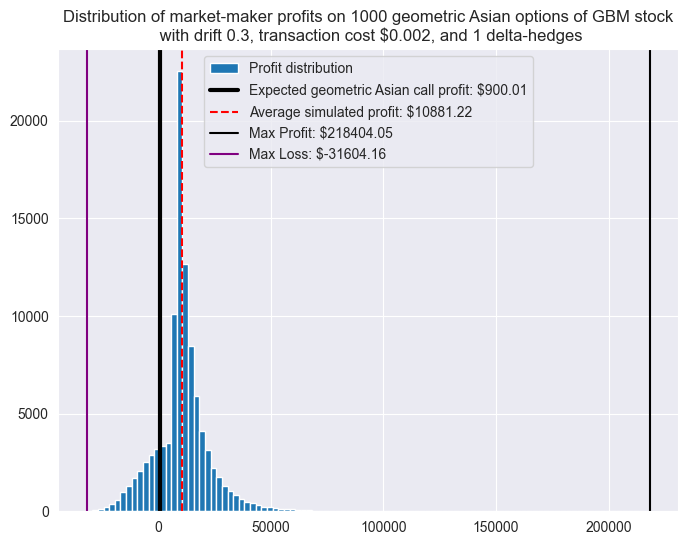

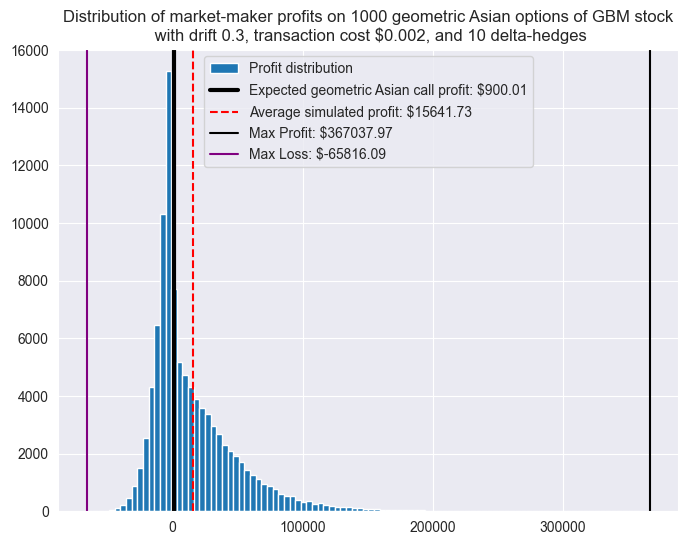

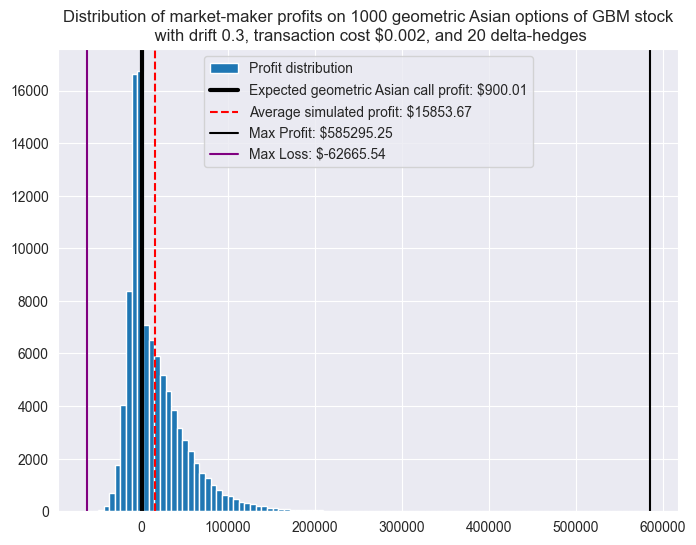

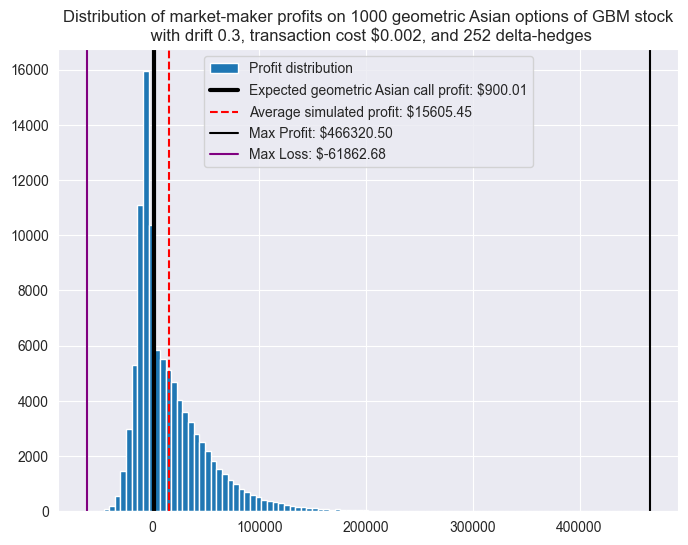

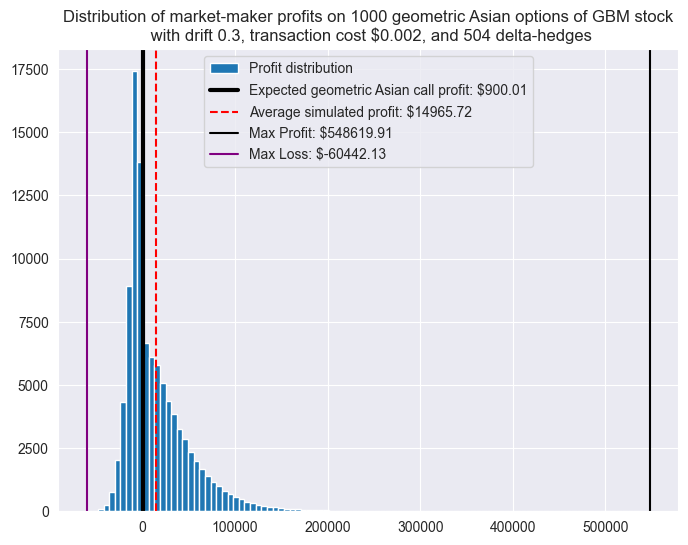

In [6]:
from utils import monte_carlo_asian_hedged, gao_price

S0 = 100
K = 100
sigma = 0.41
t = 1
r = 0.045
mu = 0.3
n_sims = 100_000
tr_cost = 0.002
n_options = 1_000
premium = gao_price(S0, K, sigma + 0.05, t, r)

steps_amounts = [1, 10, 20, 252, 504]

for n_steps in steps_amounts:
    call_value_distribution = monte_carlo_asian_hedged(
        S0,
        K,
        sigma,
        t,
        r,
        mu,
        n_sims,
        n_steps,
        geometric=True,
        return_distribution=True,
        option_type="call",
    )

    profit_distribution = n_options * (
        premium - call_value_distribution - tr_cost * n_steps
    )
    average_profit = np.mean(profit_distribution)

    plt.figure(figsize=(8, 6))

    plt.hist(profit_distribution, bins=100, label="Profit distribution")

    plt.axvline(
        n_options * (premium - gao_price(S0, K, sigma, t, r)),
        color="black",
        lw=3,
        label=f"Expected geometric Asian call profit: ${n_options*(premium - gao_price(S0,K,sigma,t,r)):.2f}",
    )

    plt.axvline(
        average_profit,
        ls="--",
        color="red",
        label=f"Average simulated profit: ${average_profit:.2f}",
    )

    profit_max = np.max(profit_distribution)
    profit_min = np.min(profit_distribution)
    plt.axvline(profit_max, color="black", label=f"Max Profit: ${profit_max:.2f}")
    plt.axvline(profit_min, color="purple", label=f"Max Loss: ${profit_min:.2f}")

    plt.title(
        f"Distribution of market-maker profits on {n_options} geometric Asian options of GBM stock\n with drift {mu}, transaction cost ${tr_cost}, and {n_steps} delta-hedges"
    )
    plt.legend()
    plt.show()

Note that the average simulated profit is always significantly more than the expected profit from the analytic formula.  Running the same simulation with a negative drift $\mu = -0.4$, one instead obtains large losses.

One issue might be that the delta-hedging is in fact discarding the path so far, and just computing delta as if the previous path did not matter.  Instead, one should keep track of the path so far, and compute delta conditionally on the (geometric) average up to the point.

One can in fact express the conditional delta in terms of the standard delta with effective parameters.  At time $t_i$:
$$
\Delta_i(S_{t_i}, G_{t_i}) = \frac{\partial S_\text{eff}}{\partial S_{t_i}} \Delta_{C_0}(S_\text{eff}, K, \sigma_\text{eff}, t - t_i),
$$
where $G_{t_i}$ is the geometric average up to time $t_i$, $S_\text{eff} = G_{t_i}^{t_i/t} S_{t_i}^{1 - t_i/t}$ by the properties of geometric averages, and $\sigma_\text{eff} = \sigma \sqrt{\frac{t - t_i}{3t}}$.  One moreover computes $\frac{\partial S_\text{eff}}{\partial S_{t_i}} = \frac{t-t_i}{t} \frac{S_\text{eff}}{S_{t_i}}$.

Another issue is that our delta-hedging simulations so far have assumed that at each rebalancing step we are taking out or depositing the incremental P&L.  In other words, the portfolio does not have zero cash flow before maturity.  In real world, hedging portfolios instead are *self-financing*: at each step the portfolio holds $\Delta_i$ shares of stock and $B_i$ of cash/bonds.  Hence, the portfolio value is $V_i = \Delta_i S_i + B_i$.  The bond grows at the risk-free rate, and thus updates as $B_{i+1} = B_i e^{r dt}$, and there is no cash-flow entering or exiting the portfolio at intermediate times.

##### A different implementation
Here is another trial (from `utils.py`) at implementing a self-financing hedging portfolio for Asian options that takes into account the discussion above.
```python
def mc_asian_sf_hedged(S0, K, sigma, t, r, mu, premium, n_sims, n_steps, geometric=False, option_type="call"):
    """Market-maker's profits on a self-financing Asian option delta-hedging portfolio
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    premium (float): Premium of selling one option
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in the average

    Returns:
    If returns 
    """
    dt = t / n_steps
    times = np.linspace(0, t, n_steps + 1)

    paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)

    if geometric:
        S = np.exp(np.mean(np.log(paths), axis=1))  # geometric mean of prices
    else:
        S = np.mean(paths, axis=1)  # arithmetic mean of prices

    if option_type == "call":
        discounted_payoff = np.exp(-r * t) * np.maximum(S - K, 0)
    elif option_type == "put":
        discounted_payoff = np.exp(-r * t) * np.maximum(K - S, 0)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))

    # initial delta and bond position
    Delta = gao_delta(S0, K, sigma, t, r, option_type=option_type)
    V = premium
    B = V - Delta * S0

    # initial geometric average (for conditional delta computation)
    G = np.full(n_sims, S0)

    for i in range(n_steps):
        S_next = paths[:, i+1]

        # bond grows at risk-free rate
        B *= np.exp(r * dt)

        # update total portfolio
        V = Delta * S_next + B

        # update geometric average
        G = np.exp( ( (i+1)*np.log(G) + np.log(S_next) ) / (i+2) )

        # compute new delta
        tau = t - times[i+1]
        S_eff = G * ((S_next / G)**(1-(i+1)/n_steps))
        sigma_eff = sigma * np.sqrt((1-(i+1)/n_steps)/3)
        Delta = (1-(i+1)/n_steps) * (S_eff / S_next) * gao_delta(S_eff, K, sigma_eff, t - dt * n_steps, r, option_type=option_type)

        # rebalance bond position
        B = V - Delta * S_next

    discounted_profit_of_call_with_hedging = discounted_payoff - V * np.exp(-r*t)

    return premium - discounted_profit_of_call_with_hedging
```

Below are some simulations with the new approach.

/home/roberto/Desktop/Learning/Quant finance bootcamp/Project/utils.py:98: RuntimeWarning: divide by zero encountered in divide
  d1 = np.sqrt(3)*(np.log(S0/K) + (b + sigma**2 / 6)*t) / (sigma * np.sqrt(t))


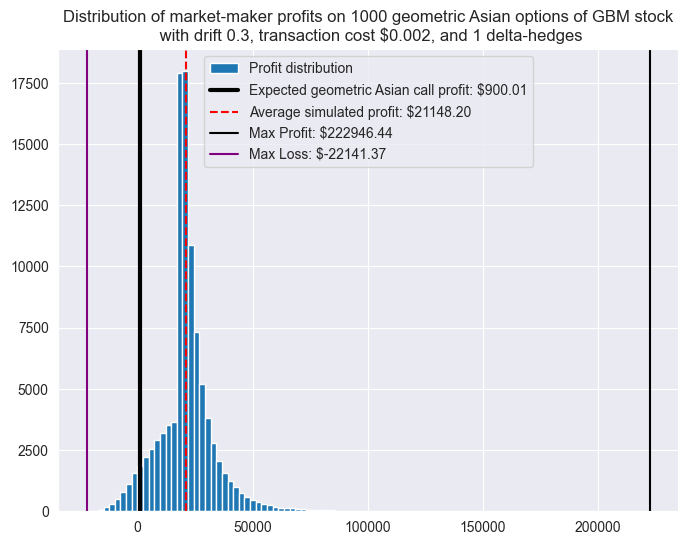

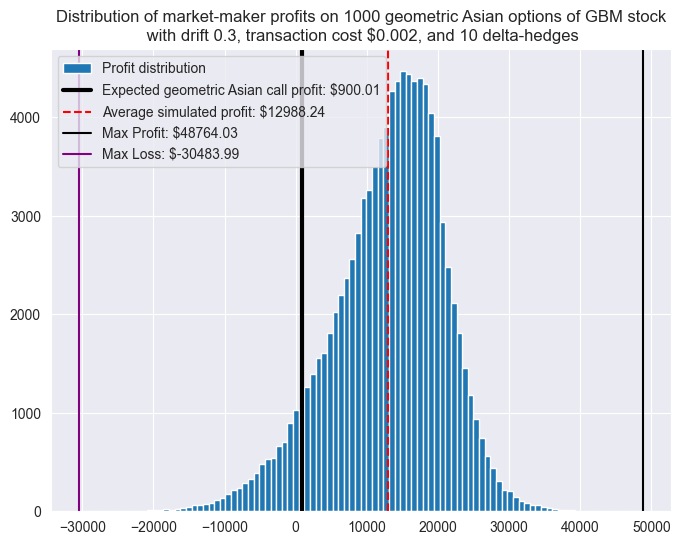

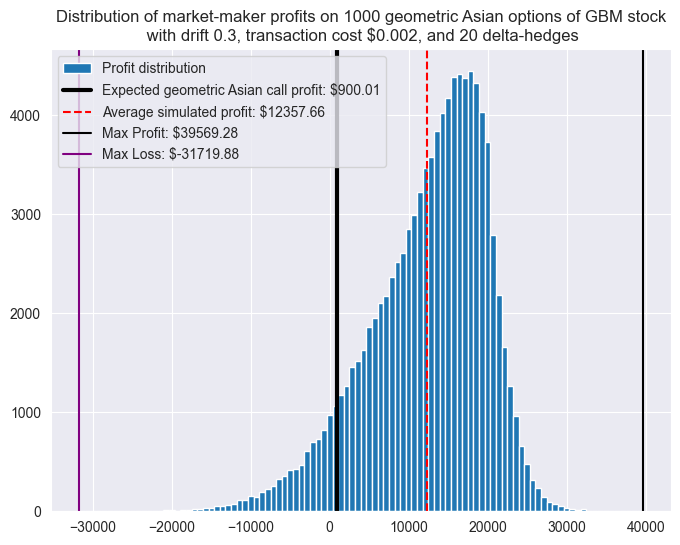

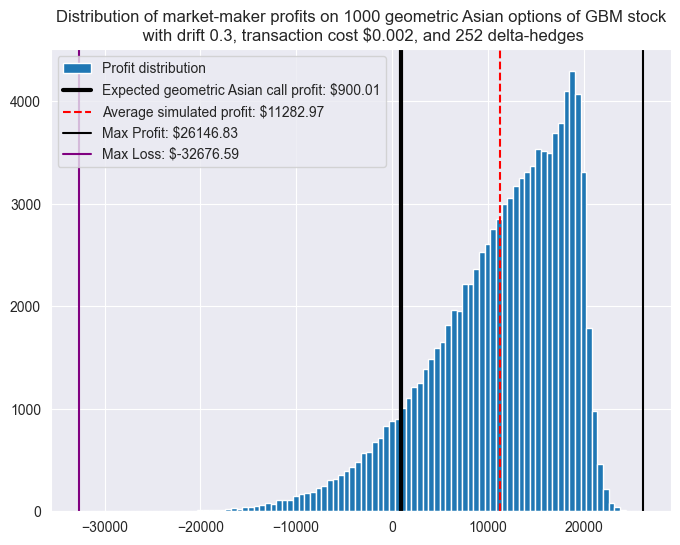

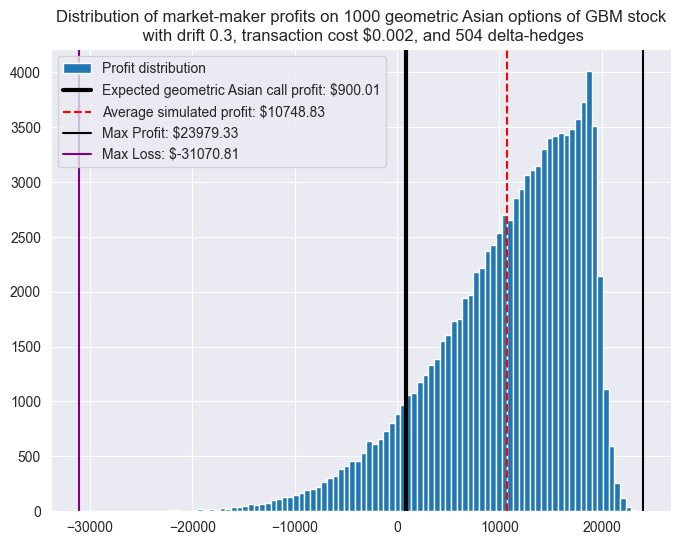

In [7]:
from utils import mc_asian_sf_hedged, gao_price

S0 = 100
K = 100
sigma = 0.41
t = 1
r = 0.045
mu = 0.3
n_sims = 100_000
tr_cost = 0.002
n_options = 1_000
premium = gao_price(S0, K, sigma + 0.05, t, r)

steps_amounts = [1, 10, 20, 252, 504]

for n_steps in steps_amounts:
    unit_profits_distribution = mc_asian_sf_hedged(
        S0, K, sigma, t, r, mu, premium, n_sims, n_steps, geometric=True
    )

    profit_distribution = n_options * (unit_profits_distribution - tr_cost * n_steps)
    average_profit = np.mean(profit_distribution)

    plt.figure(figsize=(8, 6))

    plt.hist(profit_distribution, bins=100, label="Profit distribution")

    plt.axvline(
        n_options * (premium - gao_price(S0, K, sigma, t, r)),
        color="black",
        lw=3,
        label=f"Expected geometric Asian call profit: ${n_options*(premium - gao_price(S0,K,sigma,t,r)):.2f}",
    )

    plt.axvline(
        average_profit,
        ls="--",
        color="red",
        label=f"Average simulated profit: ${average_profit:.2f}",
    )

    profit_max = np.max(profit_distribution)
    profit_min = np.min(profit_distribution)
    plt.axvline(profit_max, color="black", label=f"Max Profit: ${profit_max:.2f}")
    plt.axvline(profit_min, color="purple", label=f"Max Loss: ${profit_min:.2f}")

    plt.title(
        f"Distribution of market-maker profits on {n_options} geometric Asian options of GBM stock\n with drift {mu}, transaction cost ${tr_cost}, and {n_steps} delta-hedges"
    )
    plt.legend()
    plt.show()

This is still very much off.  However, it seems to be more stable under different values of drift, so at least seems to better hedge against non-risk-free situations.

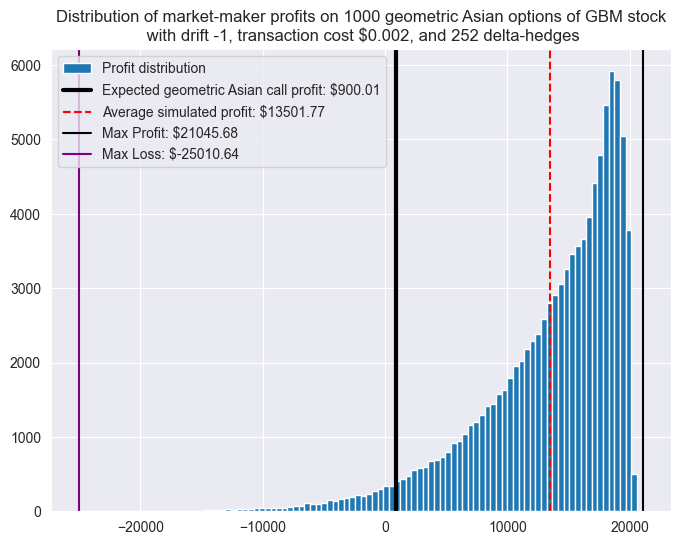

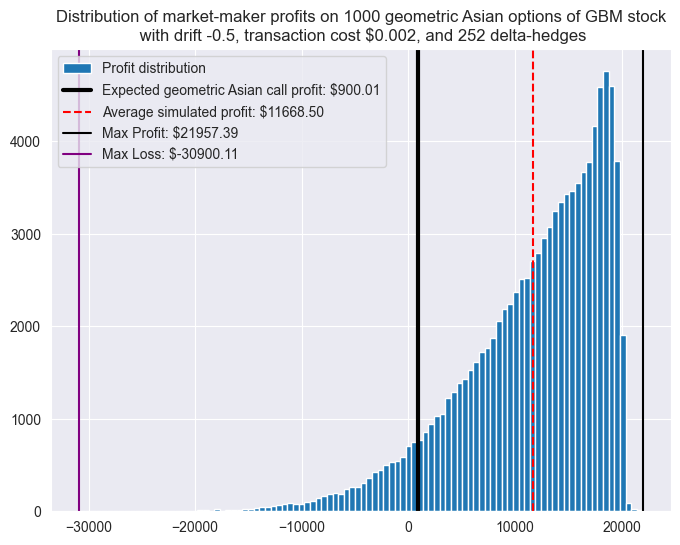

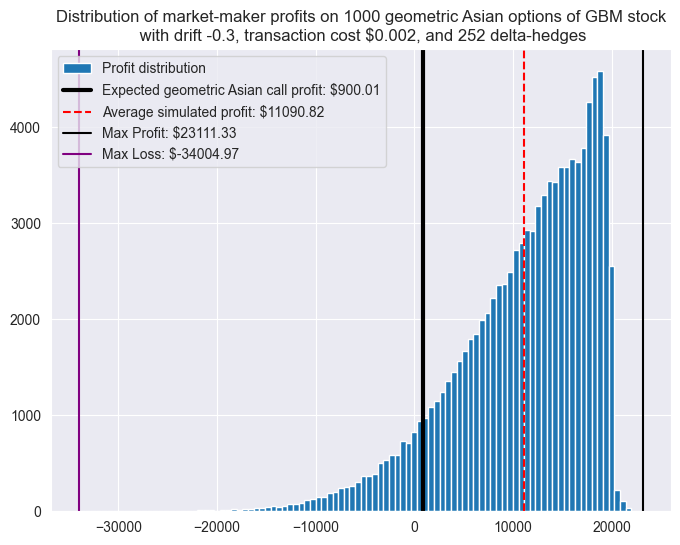

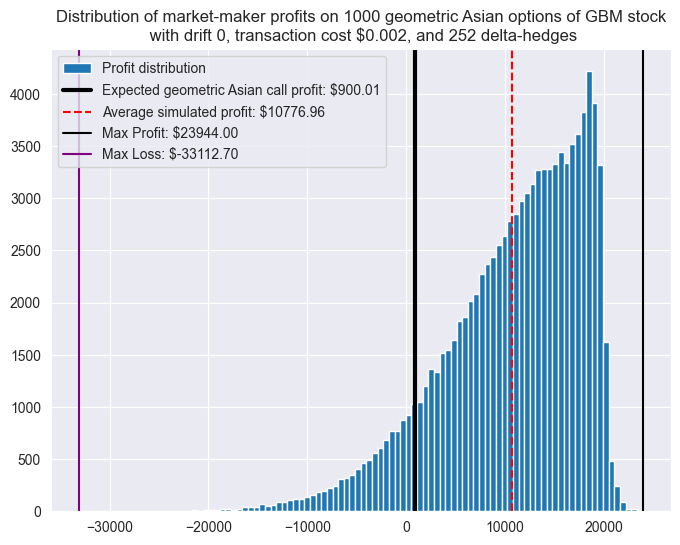

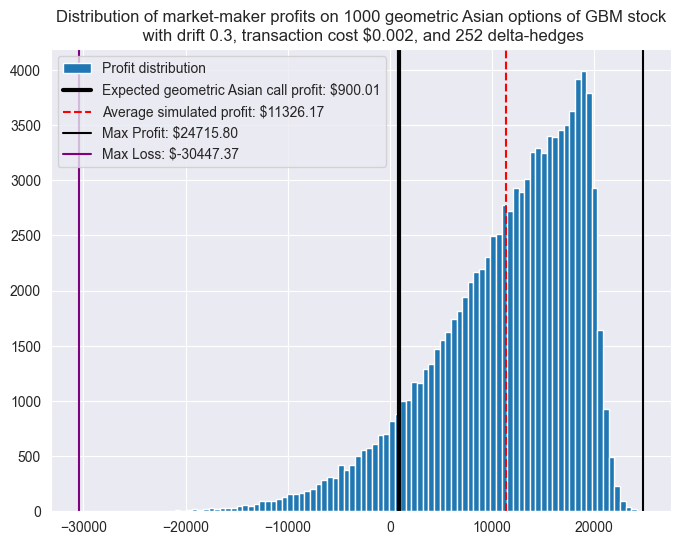

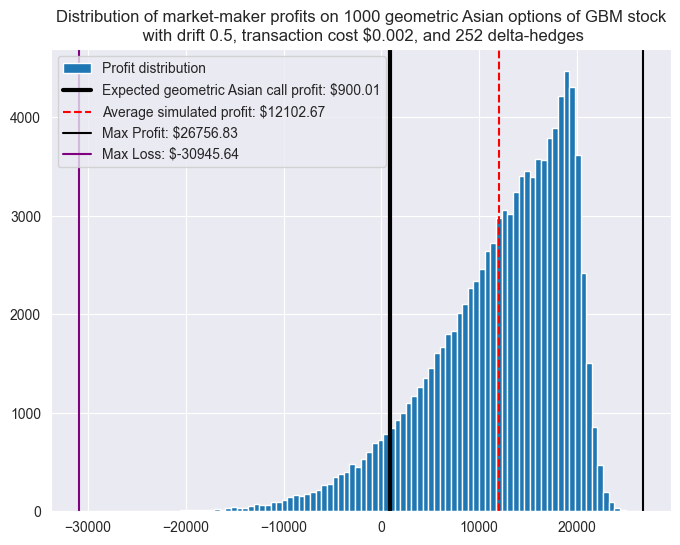

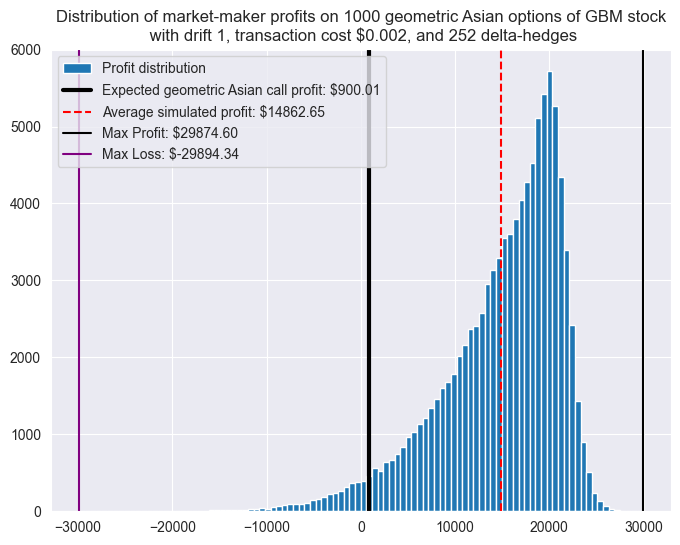

In [8]:
S0 = 100
K = 100
sigma = 0.41
t = 1
r = 0.045
n_sims = 100_000
tr_cost = 0.002
n_options = 1_000
premium = gao_price(S0, K, sigma + 0.05, t, r)
n_steps = 252

mu_amounts = [-1, -0.5, -0.3, 0, 0.3, 0.5, 1]

for mu in mu_amounts:
    unit_profits_distribution = mc_asian_sf_hedged(
        S0, K, sigma, t, r, mu, premium, n_sims, n_steps, geometric=True
    )

    profit_distribution = n_options * (unit_profits_distribution - tr_cost * n_steps)
    average_profit = np.mean(profit_distribution)

    plt.figure(figsize=(8, 6))

    plt.hist(profit_distribution, bins=100, label="Profit distribution")

    plt.axvline(
        n_options * (premium - gao_price(S0, K, sigma, t, r)),
        color="black",
        lw=3,
        label=f"Expected geometric Asian call profit: ${n_options*(premium - gao_price(S0,K,sigma,t,r)):.2f}",
    )

    plt.axvline(
        average_profit,
        ls="--",
        color="red",
        label=f"Average simulated profit: ${average_profit:.2f}",
    )

    profit_max = np.max(profit_distribution)
    profit_min = np.min(profit_distribution)
    plt.axvline(profit_max, color="black", label=f"Max Profit: ${profit_max:.2f}")
    plt.axvline(profit_min, color="purple", label=f"Max Loss: ${profit_min:.2f}")

    plt.title(
        f"Distribution of market-maker profits on {n_options} geometric Asian options of GBM stock\n with drift {mu}, transaction cost ${tr_cost}, and {n_steps} delta-hedges"
    )
    plt.legend()
    plt.show()

Computing the same with arithmetic Asian options (using geometric deltas as proxies) we obtain the following profit distributions.

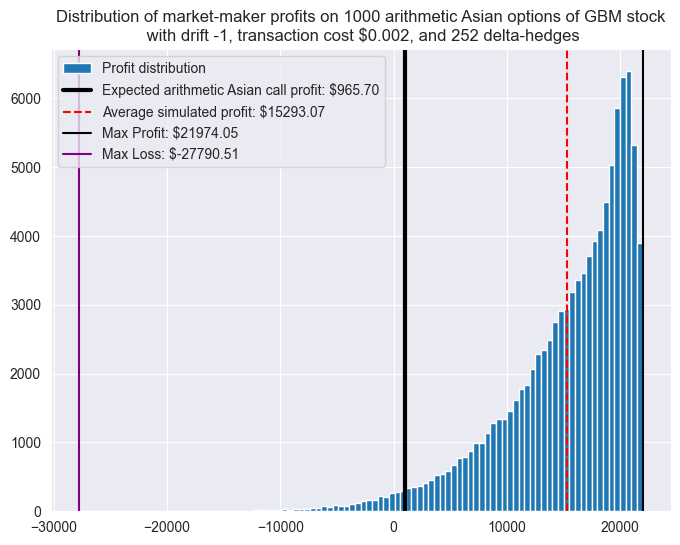

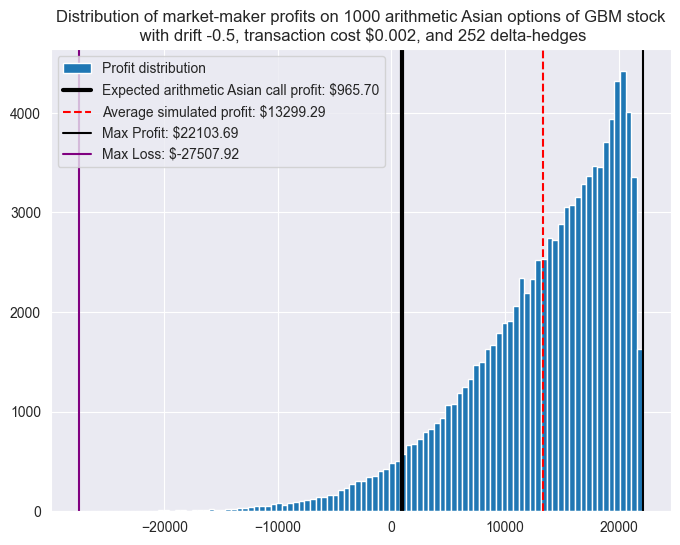

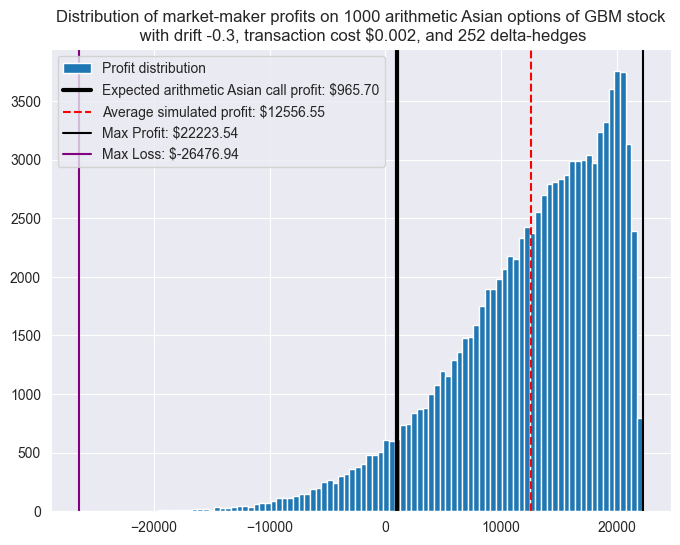

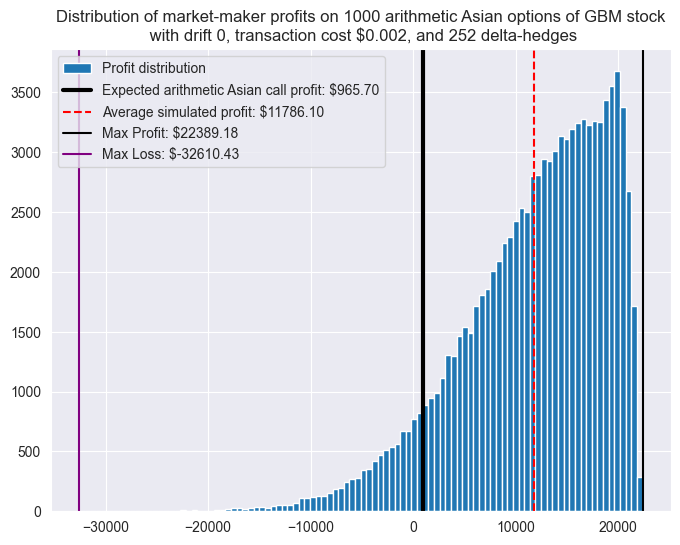

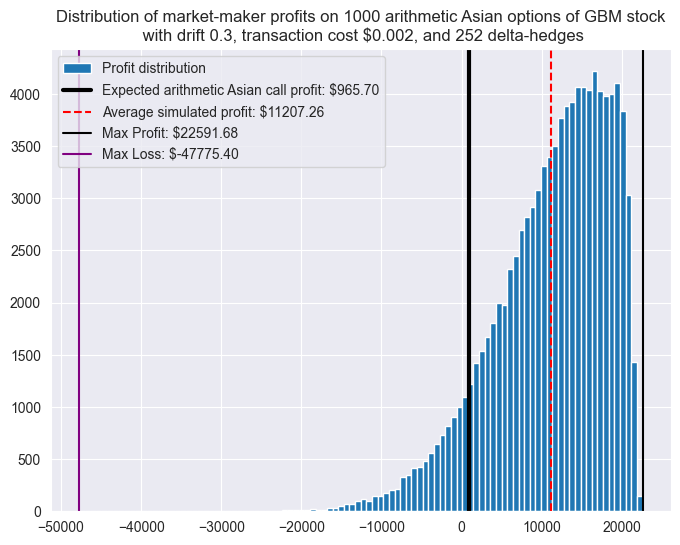

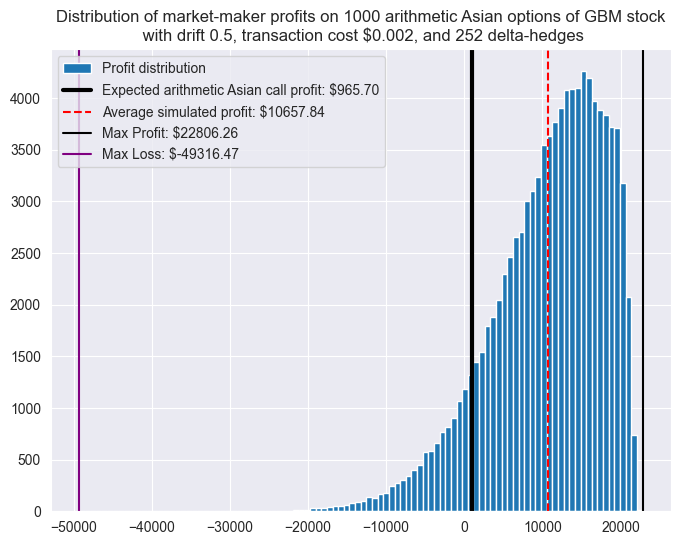

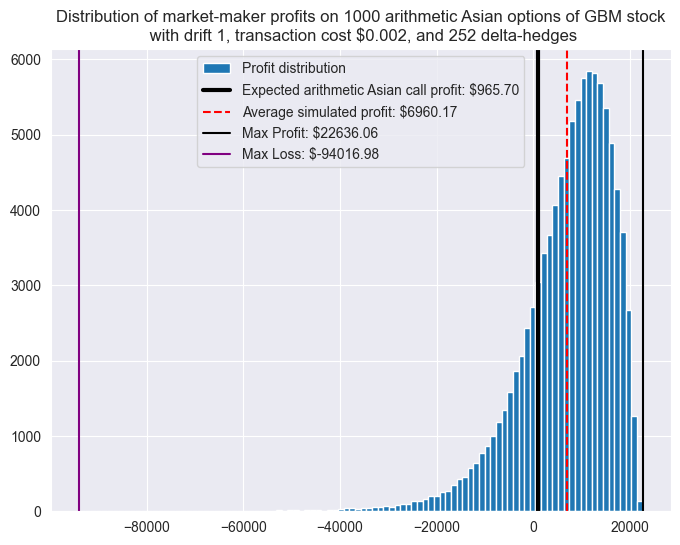

In [9]:
S0 = 100
K = 100
sigma = 0.41
t = 1
r = 0.045
n_sims = 100_000
tr_cost = 0.002
n_options = 1_000

n_steps = 252
premium = monte_carlo_asian(
    S0, K, sigma + 0.05, t, r, 0, n_sims, n_steps, return_distribution=False
)
aao_price = monte_carlo_asian(
    S0, K, sigma, t, r, 0, n_sims, n_steps, return_distribution=False
)


mu_amounts = [-1, -0.5, -0.3, 0, 0.3, 0.5, 1]

for mu in mu_amounts:
    unit_profits_distribution = mc_asian_sf_hedged(
        S0, K, sigma, t, r, mu, premium, n_sims, n_steps, geometric=False
    )

    profit_distribution = n_options * (unit_profits_distribution - tr_cost * n_steps)
    average_profit = np.mean(profit_distribution)

    plt.figure(figsize=(8, 6))

    plt.hist(profit_distribution, bins=100, label="Profit distribution")

    plt.axvline(
        n_options * (premium - aao_price),
        color="black",
        lw=3,
        label=f"Expected arithmetic Asian call profit: ${n_options*(premium - aao_price):.2f}",
    )

    plt.axvline(
        average_profit,
        ls="--",
        color="red",
        label=f"Average simulated profit: ${average_profit:.2f}",
    )

    profit_max = np.max(profit_distribution)
    profit_min = np.min(profit_distribution)
    plt.axvline(profit_max, color="black", label=f"Max Profit: ${profit_max:.2f}")
    plt.axvline(profit_min, color="purple", label=f"Max Loss: ${profit_min:.2f}")

    plt.title(
        f"Distribution of market-maker profits on {n_options} arithmetic Asian options of GBM stock\n with drift {mu}, transaction cost ${tr_cost}, and {n_steps} delta-hedges"
    )
    plt.legend()
    plt.show()

In this case, the strategy has more sensibility to the drift term, which should be expected since the delta used is the one of the geometric option.  However, the outcome still seems to be relatively stable with respect to drift.